In [1]:
#!pip instal hide_code

In [2]:
from collections import Counter
from datetime import datetime, timedelta, date
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from util.config import versioned
from util.polish import TERYT
from scrapers.pkw.sources import election_date
from analysis.utils import drop_duplicates, read_enriched, extract_companies

In [3]:
teryt = "06"

In [4]:
local_good = read_enriched(teryt)
print(f"Znaleziono {len(local_good)} osób")

Missing teryt: {'0461', '1110', '0206', '9558', '9249', '2200', '4370', '1411', '4327', '2478', '1813', '1150', '6120', '0203', '1402', '3206', '0265', '2416', '1817', '1434', '1424', '0225', '1112', '3310', '1403', '0401', '2924', '7170', '1811', '6140', '3101', '1430', '9510', '3201', '3633', '0414', '3011', '1427', '3021', '9515', '0405', '3012', '6100', '2818', '4329', '3217', '2003', '6030', '6201', '9570', '1400', '6181', '03', '9554', '0211', '7120', '1821', '0221', '1426', '4331', '1409', '1431', '6160', '9524', '2408', '1114', '4310', '9567', '2806', '1800', '0400', '3063', '6552', '2002', '2261'}
Znaleziono 292 osób


In [5]:
local_good[local_good["krs_name"] == "Jacek Adam Boczkaja"]["election_before_work"]

Series([], Name: election_before_work, dtype: timedelta64[ns])

In [6]:
local_companies = pd.DataFrame(extract_companies(local_good), columns=["KRS", "Nazwa", "Liczba ciekawych osób"])
display(local_companies)

local_companies[local_companies["Nazwa"].str.isnumeric()]["KRS"].to_list()

,KRS,Nazwa,Liczba ciekawych osób
0,0000047934,LUBELSKI RYNEK HURTOWY w Elizówka,18
1,0000062896,MIEJSKIE PRZEDSIĘBIORSTWO GOSPODARKI KOMUNALNE...,16
2,0000064144,Stowarzyszenie Samorządów Powiatu Tomaszowskiego,16
3,0000306605,LUBELSKIE DWORCE w Lublin,12
4,0000092480,PORT LOTNICZY LUBLIN,9
5,0000062888,PKP LINIA HUTNICZA SZEROKOTOROWA w Zamość,7
6,0000047813,PRZEDSIĘBIORSTWO GOSPODARKI KOMUNALNEJ SPÓŁKA ...,7
7,0000013941,MIEJSKIE PRZEDSIĘBIORSTWO KOMUNIKACYJNE - LUBL...,7
8,0000054479,Zakład Gospodarki Lokalowej W Zamościu,7
9,0000025601,Towarzystwo Budownictwa Społecznego Lublin,7


[]

In [7]:
komitet_counter = Counter((elt["party"] or "").lower().strip()
        for array in local_good["elections"].to_list()
        for elt in array)
komitet_counter.most_common(5)

[('komitet wyborczy prawo i sprawiedliwość', 90),
 ('komitet wyborczy platforma obywatelska rp', 55),
 ('komitet wyborczy polskie stronnictwo ludowe', 53),
 ('', 31),
 ('komitet wyborczy akcja wyborcza solidarność', 28)]

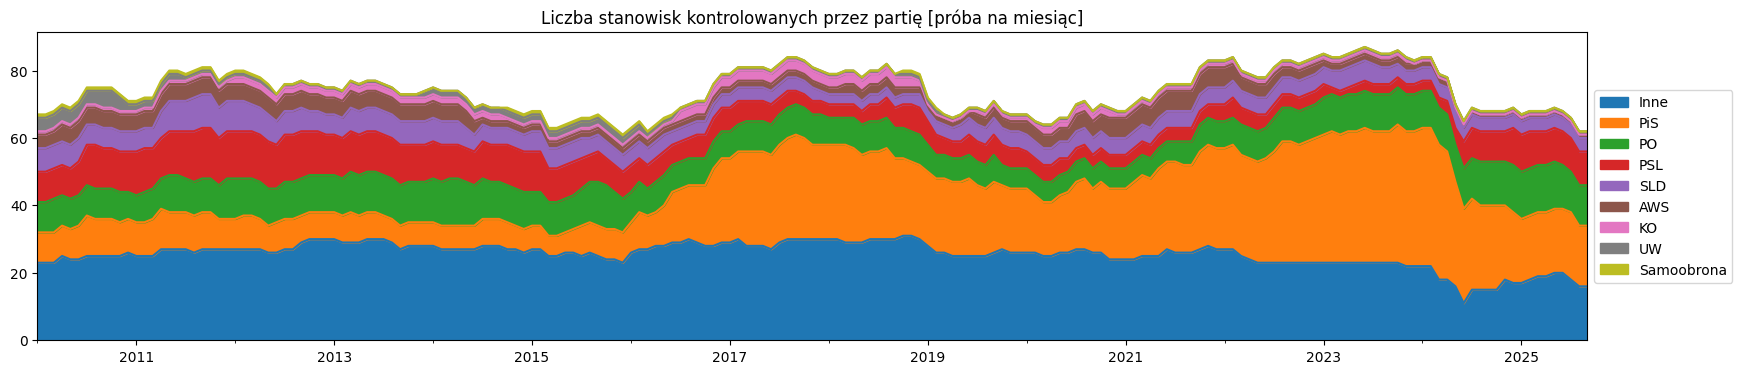

In [8]:
all_parties = set(party for parties in local_good["parties_simplified"].to_list() for party in parties)
local = {
 'Blok Samorządowy Razem',
 'Edward Pietrzyk',
 'Razem dla Radomska',
 'Razem dla Skierniewic',
 'Zbigniew Burzyński',
 'Ziemia Bełchatowska',
 'KWW Plus',
}
parties = all_parties - local
# display(parties)

def party_day_score(row):
    date = row.name
    result = [0] * len(row.index)
    global local_good
    for _i, _row in local_good.iterrows():
        for emp in _row["employment"]:
            duration = timedelta(days=365 * float(emp["employed_for"]))
            start_employed: date = emp["employed_end"] - duration
            if start_employed <= date.date() <= emp["employed_end"]:
                found_a_party = True
                for idx, col in enumerate(row.index):
                    if col in _row["parties_simplified"]:
                        result[idx] += 1
                        break
                else:
                    found_a_party = False
                if not found_a_party:
                    # Add them to "Inne" section
                    result[-1] += 1
    return pd.Series(result)

parties_aggregated = None

def show_graph(unit, unit_name, start='2010/01/01', end='2025/10/01'):
    dates = pd.date_range(start=start, end=end, freq=unit)
    df = pd.DataFrame({
        party: np.random.rand(len(dates)) for party in parties | set(["Inne"])
    }, index=dates)
    # Order dataframe columns by most recent, so we will return only at once
    df = df[["PiS","KO","PO","PSL","SLD",
             #"PO+PiS",
             "Samoobrona","AWS","UW","Inne"]]
    # display(df)
    
    party_stats = pd.DataFrame({}, columns=df.columns)
    party_stats[df.columns] = df.apply(party_day_score, axis=1)
    global parties_aggregated
    parties_aggregated = party_stats.sum(0).sort_values(ascending=False)
    descending_party_popularity = parties_aggregated.index
    party_stats = party_stats[descending_party_popularity]
    # display(party_stats)
    
    ax = party_stats.plot.area(figsize=(20, 4))
    ax.set_title(f"Liczba stanowisk kontrolowanych przez partię [próba na {unit_name}]")
    ax.legend(loc="center left", bbox_to_anchor=(1.0,0.5))

show_graph("ME", "miesiąc")

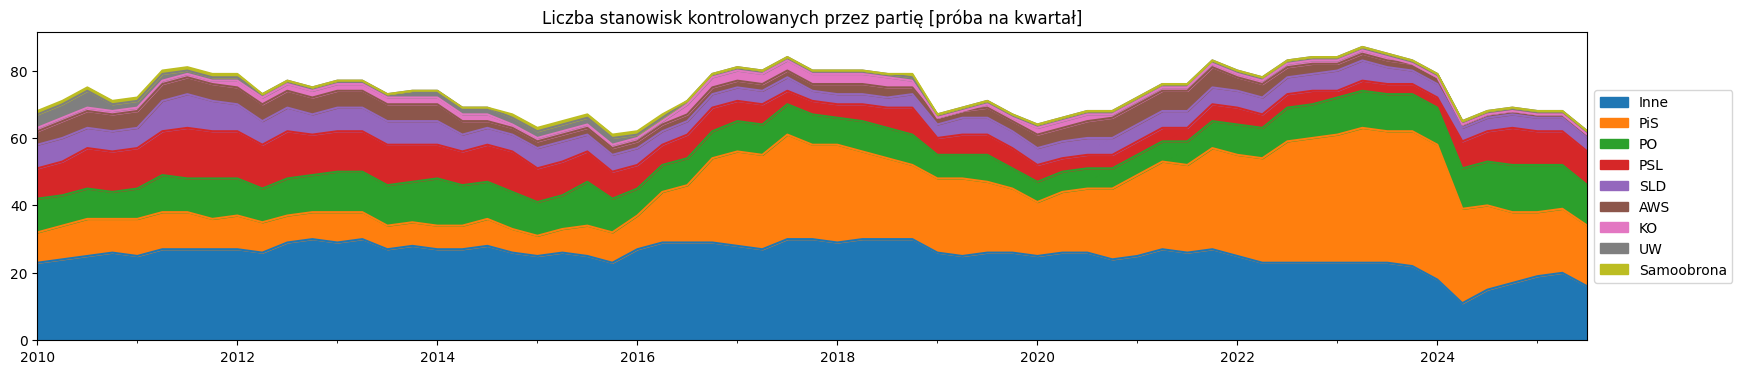

In [9]:
show_graph("QE", "kwartał")

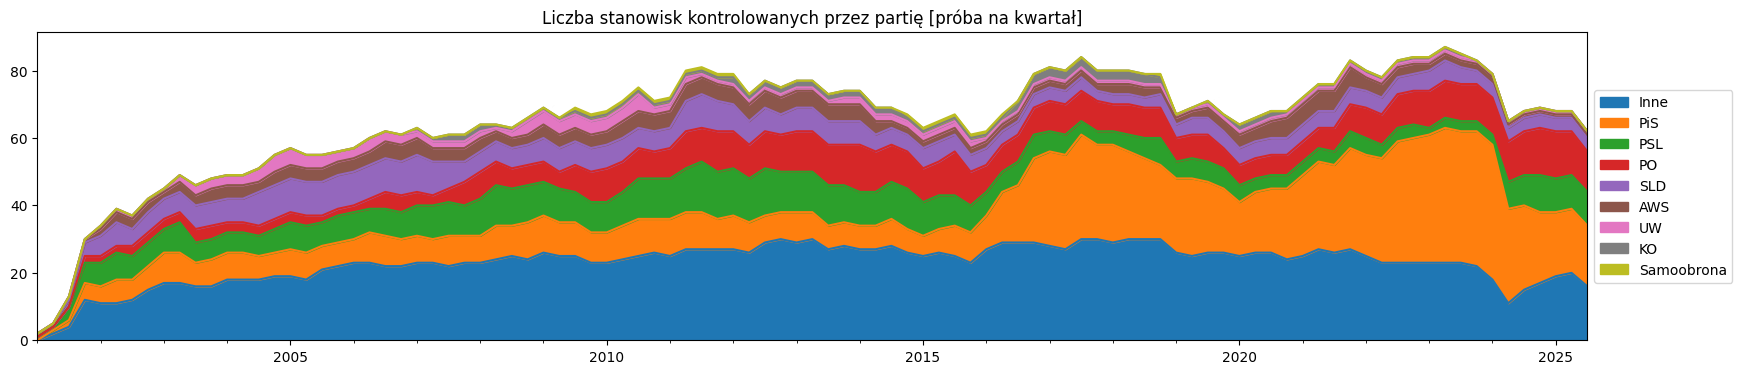

In [10]:
show_graph("QE", "kwartał", start="2001/01/01")

Text(0.5, 1.0, 'Łączny czas kontroli przez partie')

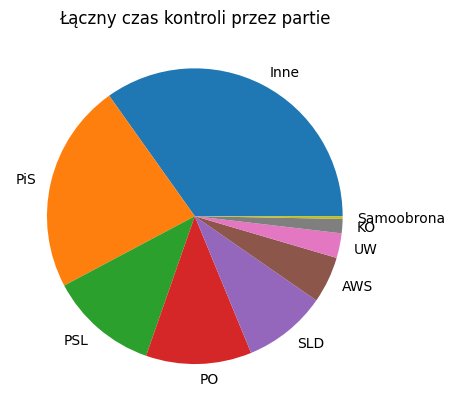

In [11]:
ax = parties_aggregated.plot.pie()
ax.set_title("Łączny czas kontroli przez partie")

Text(0.5, 0, 'Data ostatniego zatrudnienia')

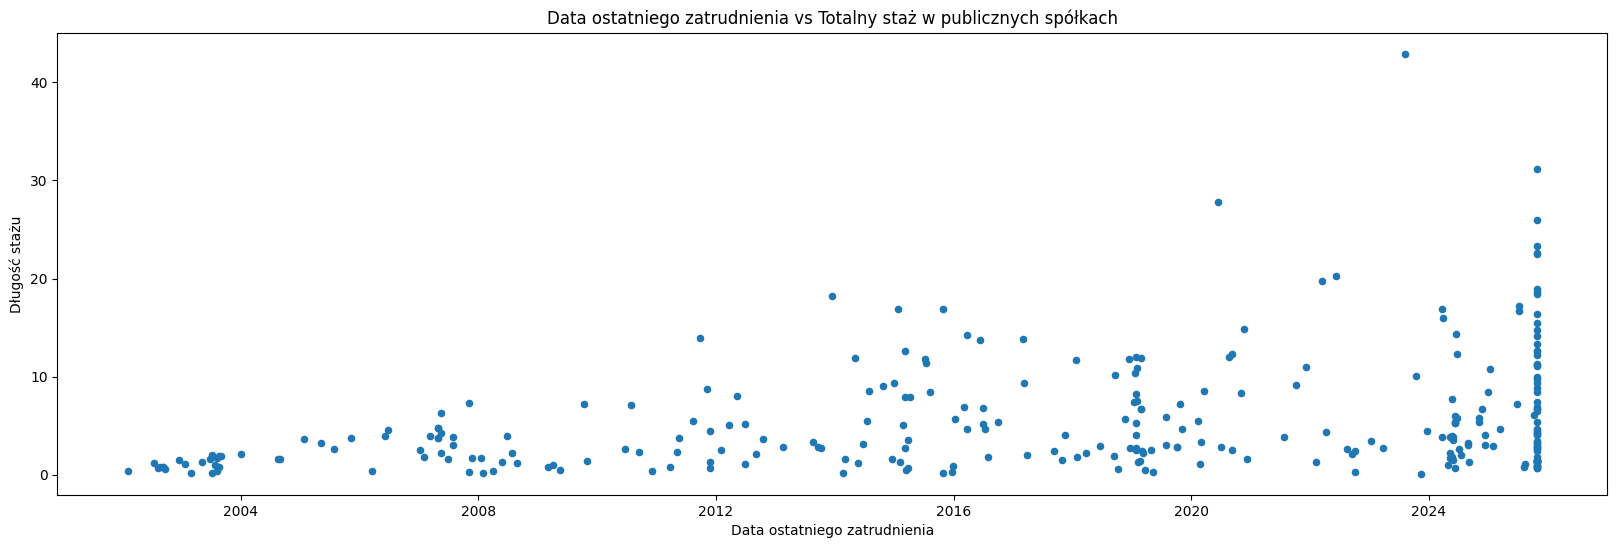

In [12]:
local_good["employed_total_years"] = local_good[("employed_total")].apply(lambda d: d.days / 365)
ax = local_good[["last_employed", "employed_total_years"]].plot.scatter(x="last_employed", y="employed_total_years", style=".", figsize=(20, 6))
ax.set_title("Data ostatniego zatrudnienia vs Totalny staż w publicznych spółkach")
ax.set_ylabel("Długość stażu")
ax.set_xlabel("Data ostatniego zatrudnienia")

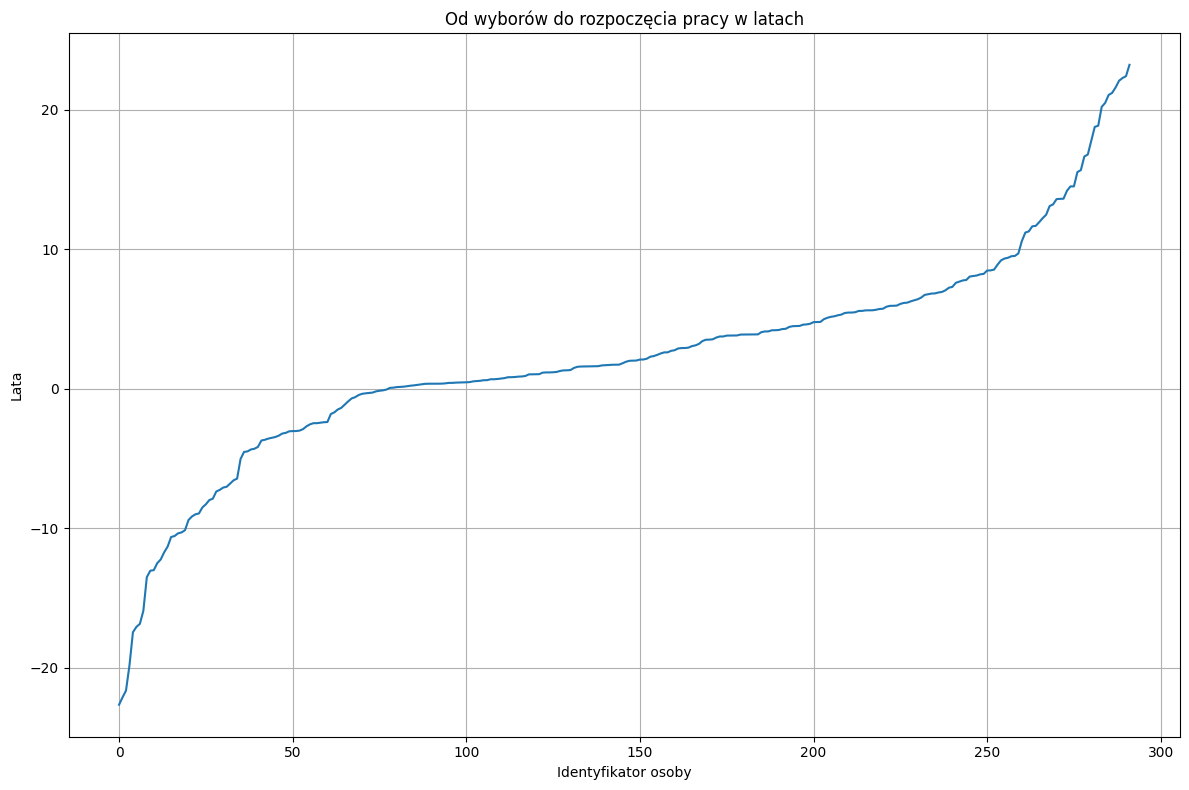

In [13]:
plt.figure(figsize=(12, 8))
ax = local_good["election_before_work"].apply(lambda duration: duration.days / 365).plot()
ax.set_xlabel("Identyfikator osoby")
ax.set_ylabel("Lata")
ax.grid(True)
ax.set_title("Od wyborów do rozpoczęcia pracy w latach")
plt.tight_layout()
plt.show()

In [14]:
d = date(year=1, month=1, day=1)
zero_delta = d - d

local_good["election_before_work_years"] = local_good["election_before_work"].apply(lambda d: d.days / 365)
longest_dur = local_good["election_before_work_years"].max()  # Use it, to put negative values after positive values of this column
local_good["election_before_work_normalized"] = local_good["election_before_work_years"].apply(lambda d: -d + longest_dur if d < 0 else d)

def calculate_position(column, smallest_good):
    # print(column)
    sort_series = local_good[column].sort_values(ascending=smallest_good)
    # display(sort_series)
    index_position = pd.Series(index=sort_series.index, data=range(len(sort_series)))
    # display(index_position)
    index_ordered = index_position.sort_index()
    # display(index_ordered)
    return index_ordered

a = calculate_position("election_before_work_normalized", smallest_good=True)
b = calculate_position("mistake_odds", smallest_good=False)
c = calculate_position("employed_total_years", smallest_good=False)
d = calculate_position("first_employed", smallest_good=False)
e = calculate_position("last_employed", smallest_good=False)

local_good["position"] = a + b + c + d + e
local_good.sort_values(by="position", inplace=True)

polish_headers = ["Pozycja", "Imię i nazwisko", "Data urodzenia", "Szansa na błąd - jeden na ...", "Od wyborów do pracy [lata]", "Łączny staż [lata]", "Pierwsze zatrudnienie", "Ostatnie zatrudnienie", "Historia"]
cleaned = pd.DataFrame({}, columns=polish_headers)
cleaned[polish_headers] = local_good[["position", "krs_name", "birth_date", "mistake_odds", "election_before_work_years", "employed_total_years", "first_employed", "last_employed", "history"]]

display(cleaned.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

,Pozycja,Imię i nazwisko,Data urodzenia,Szansa na błąd - jeden na ...,Od wyborów do pracy [lata],Łączny staż [lata],Pierwsze zatrudnienie,Ostatnie zatrudnienie,Historia
121,264,Mariusz Piotr Gwozda,1969-08-05,169947155749830.031250,1.038356,16.698630,2011-12-05,2025-07-07,Kandyduje w 1998 z list Komitet Wyborczy Akcja Wyborcza Solidarność w Zamość Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w Lublin Pracuje od 2011-12-05 do 2024-03-13 w 0000390895 Pracuje od 2011-12-18 do 2015-01-29 w MIEJSKI ZAKŁAD KOMUNIKACJI SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNOŚCIĄ W ZAMOŚCIU w Zamość Pracuje od 2024-03-20 do 2025-07-07 w PGE DYSTRYBUCJA w Lublin
84,305,Tomasz Fulara,1979-06-18,21945599.513790,0.213699,14.698630,2011-02-07,2025-10-27,Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w powiat łęczyński Pracuje od 2011-02-07 do 2024-06-18 w MIEJSKIE PRZEDSIĘBIORSTWO KOMUNIKACYJNE - LUBLIN w Lublin Pracuje od 2024-06-29 do 2025-10-27 w MIEJSKIE PRZEDSIĘBIORSTWO KOMUNIKACYJNE - LUBLIN w Lublin
91,307,Marek Łuszczyński,1969-09-10,8128000.136778,0.353425,6.668493,2019-02-27,2025-10-27,Kandyduje w 2018 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w powiat tomaszowski Pracuje od 2019-02-27 do 2025-10-27 w Stowarzyszenie Samorządów Powiatu Tomaszowskiego
79,318,Artur Aleksander Jędruszczuk,1975-07-02,160842843834660.562500,0.073973,10.978082,2010-12-18,2021-12-07,"Kandyduje w 1998 z list Komitet Wyborczy ""Młodzi Chełma"" w Chełm Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW AGATY FISZ ""POSTAW NA CHEŁM"" w Chełm Pracuje od 2010-12-18 do 2021-12-07 w Miejskie Przedsiębiorstwo Energetyki Cieplnej Chełm Kandyduje w 2014 z list Komitet Wyborczy Wyborców Agaty Fisz ""Postaw na Chełm"" w Chełm"
191,330,Jarosław Piotr Korzeń,1974-08-16,2280009227.856907,4.271233,6.668493,2019-02-27,2025-10-27,Kandyduje w 2010 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w powiat tomaszowski Kandyduje w 2014 z list Komitet Wyborczy Prawo i Sprawiedliwość w powiat tomaszowski Pracuje od 2019-02-27 do 2025-10-27 w Stowarzyszenie Samorządów Powiatu Tomaszowskiego Kandyduje w 2024 z list KW PRAWO I SPRAWIEDLIWOŚĆ w powiat tomaszowski
202,334,Piotr Leon Dreher,1975-06-25,1125899906842624.000000,4.783562,6.098630,2019-09-02,2025-10-06,Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w Lublin Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w Lublin Pracuje od 2019-09-02 do 2025-10-06 w MOTOR LUBLIN
233,363,Konrad Marek Niklewicz,1975-12-19,70949644391.116272,6.769863,4.169863,2021-08-27,2025-10-27,Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w powiat puławski Pracuje od 2021-08-27 do 2025-10-27 w TRAMWAJE WARSZAWSKIE w Warszawa
115,367,Artur Juszczak,1970-02-03,582884.869099,0.863014,9.958904,2019-09-01,2025-10-27,Kandyduje w 2002 z list KWW Adama Rychliczka w Chełm Kandyduje w 2018 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w Chełm Pracuje od 2019-09-01 do 2025-10-27 w Chełmski Park Wodny Pracuje od 2021-10-06 do 2022-03-30 w PRZEDSIĘBIORSTWO ENERGETYKI CIEPLNEJ w Zgierz Pracuje od 2022-08-03 do 2023-07-19 w FABRYKA CHEŁM w Warszawa Pracuje od 2023-05-05 do 2025-08-06 w 0000978580 Pracuje od 2025-07-15 do 2025-08-20 w 0001183960
249,371,Mariusz Robert Chudoba,1970-03-25,2094640020.283395,8.224658,6.898630,2019-02-09,2025-10-27,Kandyduje w 2010 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w Chełm Pracuje od 2019-02-09 do 2025-10-27 w Chełmskie Linie Autobusowe Pracuje od 2024-03-31 do 2024-06-04 w 0000978580
217,373,Stanisław Tomasz Misterek,1955-09-20,750599937895082.625000,5.616438,4.698630,2020-07-02,2025-03-13,Kandyduje w 2014 z list Komitet Wyborczy Polskie Stronnictwo Ludowe w lubelskie Pracuje od 2020-07-02 do 2025-03-13 w PORT LOTNICZY LUBLIN


In [15]:
# Write to output
local_output = versioned.get_path(f"people_woj_{teryt}.csv")
cleaned.to_csv(local_output,index=False)

# Write to output
companies_output = versioned.get_path(f"companies_woj_{teryt}.csv")
local_companies.to_csv(companies_output,index=False)